In [5]:
from matplotlib import pyplot as plt

import pandas as pd

from pytorch_lightning import Trainer

from gnn_tracking.postprocessing.dbscanscanner import DBSCANHyperParamScannerFixed
from gnn_tracking.training.tc import TCModule
from pytorch_lightning.utilities.model_summary import ModelSummary
from ocpaper231.plotutils import Plot
from gnn_tracking.metrics.cluster_metrics import (
    tracking_metrics_vs_pt,
    tracking_metrics_vs_eta,
)
from torch_geometric.utils import index_to_mask
from torch_geometric.data import Data
import scienceplots
from gnn_tracking.utils.loading import TrackingDataModule
import numpy as np


plt.style.use(["science", "notebook"])
from ocpaper231.data import model_exchange_path
from ocpaper231.names import variable_manager as vm

In [6]:
dm = TrackingDataModule(
    train=dict(
        dirs=[
            "/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/graphs_v8_cut/part_1/"
        ],
    ),
    val=dict(
        dirs=[
            "/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/graphs_v8_cut/part_9/"
        ],
        stop=10,
    ),
)
dm.setup(stage="fit")

[22:42:13] INFO: DataLoader will load 719 graphs (out of 719 available).
[22:42:13] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/graphs_v8_cut/part_1/data21000_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/graphs_v8_cut/part_1/data21999_s0.pt
[22:42:14] INFO: DataLoader will load 10 graphs (out of 801 available).
[22:42:14] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/graphs_v8_cut/part_9/data29000_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/graphs_v8_cut/part_9/data29009_s0.pt


In [7]:
from gnn_tracking.utils.lightning import find_latest_checkpoint
from pathlib import Path


model = "chirpy-delicate-jaguarundi"
chkpt_path = find_latest_checkpoint(
    Path(
        f"/home/kl5675/Documents/23/git_sync/hyperparameter_optimization2/scripts/legacy/lightning_logs/"
    ),
    model,
)

In [8]:
chkpt_path

PosixPath('/home/kl5675/Documents/23/git_sync/hyperparameter_optimization2/scripts/legacy/lightning_logs/chirpy-delicate-jaguarundi/checkpoints/epoch=90-step=698400.ckpt')

In [9]:
lmodel = TCModule.load_from_checkpoint(chkpt_path, map_location="cpu")

[22:42:14] DEBUG: Getting class PreTrainedECGraphTCN from module gnn_tracking.models.track_condensation_networks
/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:196: UserWarning: Attribute 'hc_in' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['hc_in'])`.
  rank_zero_warn(
[22:42:14] DEBUG: Getting class PotentialLoss from module gnn_tracking.metrics.losses
[22:42:14] DEBUG: Getting class BackgroundLoss from module gnn_tracking.metrics.losses
[22:42:14] DEBUG: Getting class DBSCANHyperParamScanner from module gnn_tracking.postprocessing.dbscanscanner


# VS EPS

In [10]:
eps = np.linspace(0.001, 1, 80)
ks = [1]  # np.arange(1, 5)
trials = []
for e in eps:
    for k in ks:
        trials.append({"eps": e, "min_samples": k})

eps_scanner = DBSCANHyperParamScannerFixed(
    trials=trials,
)
lmodel.cluster_scanner = eps_scanner

In [11]:
# class OrphanRemover:
#     def __call__(self, data: Data):
#         connected_nodes = data.edge_index.flatten().unique()
#         hit_mask = index_to_mask(connected_nodes, size=data.num_nodes)
#         ofrac = 1 - hit_mask.sum() / data.num_nodes
#         print(f"Removed {ofrac:.2%} of nodes")
#         return data.subgraph(hit_mask)

In [12]:
ModelSummary(lmodel)

  | Name            | Type                 | Params
---------------------------------------------------------
0 | model           | PreTrainedECGraphTCN | 1.9 M 
1 | potential_loss  | PotentialLoss        | 0     
2 | background_loss | BackgroundLoss       | 0     
---------------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.579     Total estimated model params size (MB)

In [13]:
trainer = Trainer(accelerator="cpu")

/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3 ...
  rank_zero_warn(
/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [14]:
_ = trainer.validate(lmodel, dm, ckpt_path="last", verbose=False)

/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:189: UserWarning: .validate(ckpt_path="last") is set, but there is no last checkpoint available. No checkpoint will be loaded.
  rank_zero_warn(
[22:43:22] INFO: DataLoader will load 10 graphs (out of 801 available).
[22:43:22] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/graphs_v8_cut/part_9/data29000_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/graphs_v8_cut/part_9/data29009_s0.pt
/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 96 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Validation: 0it [00:00, ?it/s]

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


In [15]:
print("test")

test


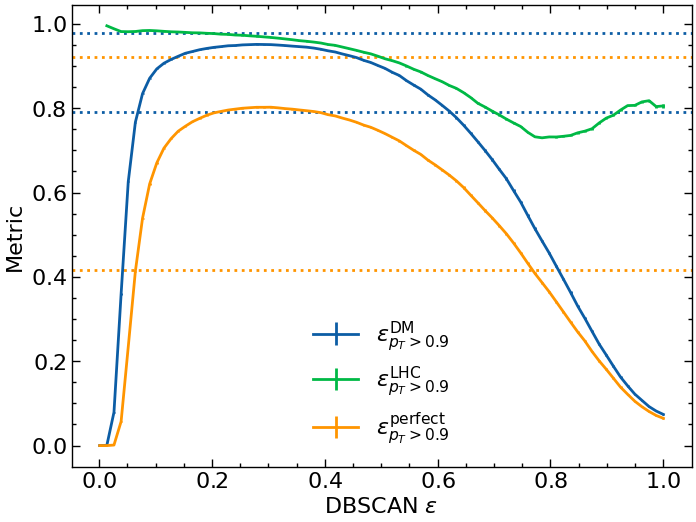

In [17]:
from pathlib import Path
from gnn_tracking.analysis.efficiencies import TracksVsDBSCANPlot

tvdp = TracksVsDBSCANPlot(
    mean_df=eps_scanner.get_results().df_mean,
    # model=model,
    # watermark="outdated",
)
tvdp.plot_var("double_majority_pt0.9")
tvdp.plot_var("lhc_pt0.9")
tvdp.plot_var("perfect_pt0.9")
tvdp.ax.legend()
tvdp.ax.axhline(0.977064, color="C0", ls=":")
tvdp.ax.axhline(0.7907116988303107, color="C0", ls=":")
tvdp.ax.axhline(0.920599, color="C2", ls=":")
tvdp.ax.axhline(0.417143, color="C2", ls=":")
tvdp.ax.get_figure().savefig("performance_vs_eps.pdf")

In [18]:
tvdp.df["double_majority_pt0.9"].max()

0.9511453517715154

In [19]:
max_dm_idx = tvdp.df["double_majority_pt0.9"].argmax()

In [27]:
max_dm_eps = tvdp.df.loc[max_dm_idx]["eps"]
max_dm_eps

0.27920253164556963

In [87]:
tvdp.df.loc[max_dm_idx][["fake_double_majority_pt0.9"]]

fake_double_majority_pt0.9    0.016611
Name: 22, dtype: float64

In [23]:
tvdp.df["perfect_pt0.9"].max()

0.802209455554714

In [19]:
df = tvdp.df
r = df.query("(`double_majority_pt0.9` > 0.9) & (min_samples == 1)")[
    ["eps", "double_majority_pt0.9"]
]
r

,eps,double_majority_pt0.9
4,0.111538,0.903718
5,0.136923,0.921044
6,0.162308,0.933125
7,0.187692,0.940753
8,0.213077,0.945495
9,0.238462,0.948407
10,0.263846,0.950337
11,0.289231,0.951092
12,0.314615,0.949621
13,0.340000,0.947149



# vs pt and eta

## Upper bound

In [29]:
from gnn_tracking.metrics.cluster_metrics import (
    tracking_metrics_data,
    tracking_metric_df,
)
from gnn_tracking.analysis.graphs import get_cc_labels
import pandas as pd


def get_truth_hc_dfs(dm):
    h_dfs = []
    c_dfs = []
    for data in dm.val_dataloader():
        y = data.y.bool()
        ei = data.edge_index[:, y]
        labels = get_cc_labels(ei, num_nodes=data.num_nodes)
        h_df = pd.DataFrame(
            {
                "c": labels,
                "id": data.particle_id,
                "pt": data.pt,
                "reconstructable": data.reconstructable,
                "eta": data.eta,
            }
        )
        c_df = tracking_metric_df(h_df)
        h_dfs.append(h_df)
        c_dfs.append(c_df)
    return h_dfs, c_dfs

In [30]:
from gnn_tracking.metrics.cluster_metrics import tracking_metrics_vs_pt


h_dfs, c_dfs = get_truth_hc_dfs(dm)

In [31]:
import numpy as np

pts = np.array(np.arange(0, 3, 0.3).tolist() + [5.0])

In [32]:
vs_pt_ul = tracking_metrics_vs_pt(h_dfs, c_dfs, pts=pts)

In [33]:
vs_pt_ul

,n_particles,n_cleaned_clusters,perfect,double_majority,lhc,fake_perfect,fake_double_majority,fake_lhc,n_particles_err,n_cleaned_clusters_err,perfect_err,double_majority_err,lhc_err,fake_perfect_err,fake_double_majority_err,fake_lhc_err,pt_min,pt_max
0,2118.5,199.0,0.014151,0.046852,1.0,0.848750,0.498319,0.0,49.677683,8.975275,0.000871,0.001304,0.0,0.008830,0.012161,0.0,0.0,0.3
1,2954.2,1049.0,0.115386,0.258172,1.0,0.674860,0.272880,0.0,85.052115,31.404175,0.001675,0.002695,0.0,0.005299,0.005097,0.0,0.3,0.6
2,1322.1,1016.5,0.488217,0.715185,1.0,0.365076,0.069904,0.0,45.769580,35.231063,0.005601,0.004451,0.0,0.006243,0.002305,0.0,0.6,0.9
3,600.4,598.5,0.910135,0.970916,1.0,0.087199,0.026284,0.0,17.710135,16.972690,0.004792,0.002186,0.0,0.005671,0.002334,0.0,0.9,1.2
4,309.0,310.0,0.926058,0.981506,1.0,0.076923,0.021681,0.0,8.884443,8.899438,0.003062,0.001734,0.0,0.004184,0.002496,0.0,1.2,1.5
5,185.5,187.2,0.930837,0.985383,1.0,0.077333,0.023303,0.0,5.895855,6.086050,0.007012,0.002762,0.0,0.007611,0.003231,0.0,1.5,1.8
6,102.6,102.4,0.938673,0.984917,1.0,0.060059,0.013738,0.0,2.565584,2.271563,0.005946,0.004676,0.0,0.005376,0.004249,0.0,1.8,2.1
7,64.8,65.0,0.934201,0.990923,1.0,0.067831,0.010932,0.0,3.717227,3.855732,0.011785,0.005234,0.0,0.008608,0.004138,0.0,2.1,2.4
8,42.1,42.1,0.926886,0.975503,1.0,0.072666,0.024128,0.0,3.219558,3.181369,0.009708,0.008234,0.0,0.011735,0.009864,0.0,2.4,2.7
9,79.7,80.3,0.922780,0.987133,1.0,0.083402,0.019470,0.0,2.440628,2.641759,0.007555,0.003412,0.0,0.007614,0.003968,0.0,2.7,5.0


In [34]:
from gnn_tracking.metrics.cluster_metrics import tracking_metrics_vs_eta

etas = np.array(np.linspace(-4, 4, 20).tolist() + [4.0])

In [35]:
etas

array([-4.        , -3.57894737, -3.15789474, -2.73684211, -2.31578947,
       -1.89473684, -1.47368421, -1.05263158, -0.63157895, -0.21052632,
        0.21052632,  0.63157895,  1.05263158,  1.47368421,  1.89473684,
        2.31578947,  2.73684211,  3.15789474,  3.57894737,  4.        ,
        4.        ])

In [36]:
vs_eta_ul = tracking_metrics_vs_eta(h_dfs, c_dfs, etas=etas)

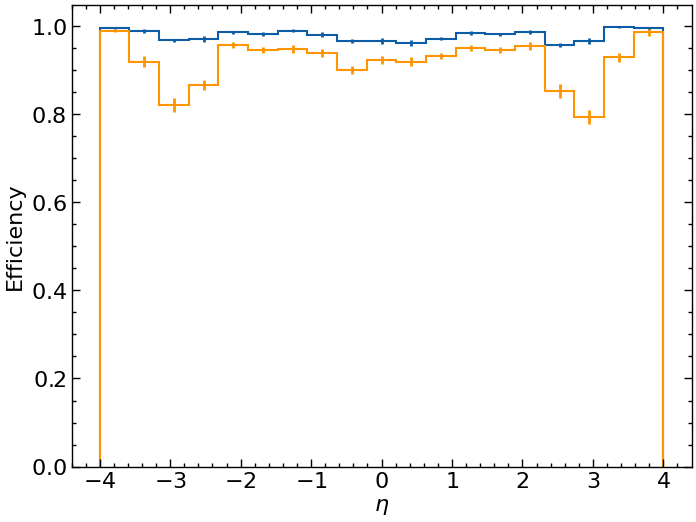

In [37]:
p = PerformancePlot(df=vs_eta_ul, xs=etas, var=vm["eta"].latex)  # , model=model)
p.plot_var("double_majority", "C0", label=vm["double_majority_pt0.9"].latex)
p.plot_var("perfect", "C2", label=vm["perfect_pt0.9"].latex)

In [38]:
from gnn_tracking.metrics.cluster_metrics import tracking_metrics_vs_eta

vs_eta_ul = tracking_metrics_vs_eta(h_dfs, c_dfs, etas=etas)

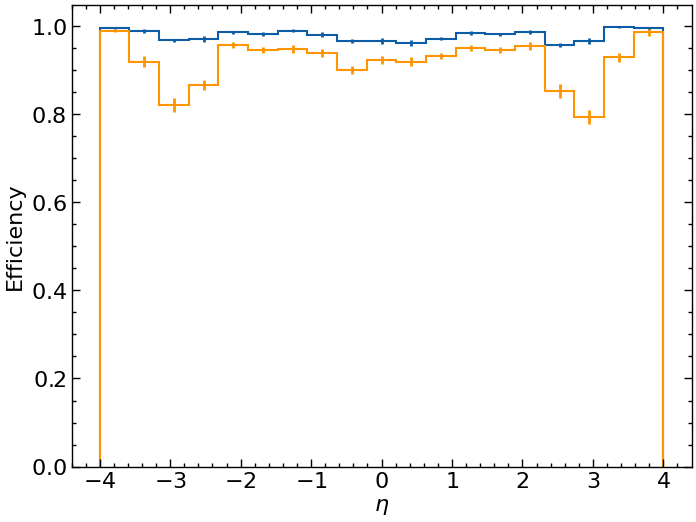

In [39]:
p = PerformancePlot(df=vs_eta_ul, xs=etas, var=vm["eta"].latex)  # , model=model)
p.plot_var("double_majority", "C0", label=vm["double_majority_pt0.9"].latex)
p.plot_var("perfect", "C2", label=vm["perfect_pt0.9"].latex)


## Actual performance

In [40]:
# eyeballed
best_eps = max_dm_eps
best_k = 1

In [41]:
from gnn_tracking.postprocessing.dbscanscanner import DBSCANPerformanceDetails

detail_scanner = DBSCANPerformanceDetails(eps=best_eps, min_samples=best_k)
lmodel.cluster_scanner = detail_scanner

trainer = Trainer(accelerator="cpu")
_ = trainer.validate(lmodel, dm, ckpt_path="last", verbose=False)

/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3 ...
  rank_zero_warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:189: UserWarning: .validate(ckpt_path="last") is set, but there is no last checkpoint available. No checkpoint will be loaded.
  rank_zero_warn(
[23:03:31] INFO: DataLoader will load 10 graphs (out of 801 available).
[23:03:31] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/graphs_v8_cut/part_9

Validation: 0it [00:00, ?it/s]

In [42]:
h_dfs, c_dfs = detail_scanner.get_results()

In [25]:
import pickle

with Path("h_dfs.pkl").open("wb") as f:
    pickle.dump(h_dfs, f)
with Path("c_dfs.pkl").open("wb") as f:
    pickle.dump(c_dfs, f)

In [43]:
vs_pt = tracking_metrics_vs_pt(h_dfs, c_dfs, pts=pts)
vs_eta = tracking_metrics_vs_eta(h_dfs, c_dfs, etas=etas)

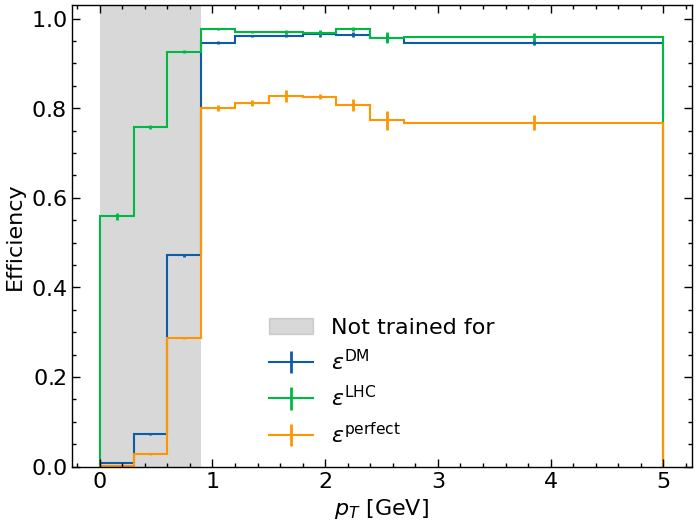

In [44]:
p = PerformancePlot(
    df=vs_pt, df_ul=None, xs=pts, var=vm["pt"].latex + " [GeV]"
)  # , model=model)
p.add_blocked(0, 0.9)
p.plot_var("double_majority", "C0")
p.plot_var("lhc", "C1")
p.plot_var("perfect", "C2")
p.add_legend()
p.ax.get_figure().savefig("vs_pt.pdf")

/tmp/ipykernel_2345810/4155649600.py:44: UserWarning: The label '_' of (<matplotlib.patches.StepPatch object at 0x151531bf48b0>, <ErrorbarContainer object of 3 artists>) starts with '_'. It is thus excluded from the legend.
  self.ax.legend(all_handles, all_labels, **kwargs)


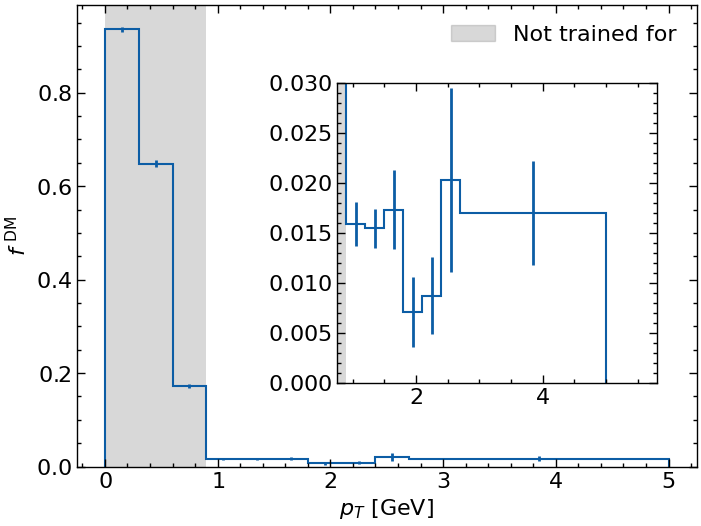

In [73]:
p = PerformancePlot(
    df=vs_pt,
    df_ul=None,
    xs=pts,
    var=vm["pt"].latex + " [GeV]",
    y_label=r"$f^{\,\,\mathrm{DM}}$",
)
p.add_blocked(0, 0.9)
# p.ax.set_ylim(0., 0.05)
p.plot_var("fake_double_majority", "C0", label="_")
p.add_legend()

left, bottom, width, height = [0.45, 0.25, 0.4, 0.5]
ax2 = p.ax.get_figure().add_axes([left, bottom, width, height])
p = PerformancePlot(df=vs_pt, df_ul=None, xs=pts, var="", y_label="", ax=ax2)
p.add_blocked(0, 0.9)
p.ax.set_xlim(0.75, 5.8)
p.ax.set_ylim(0.0, 0.03)
p.plot_var("fake_double_majority", "C0", label="_")

p.ax.get_figure().savefig("fake_vs_pt.pdf")

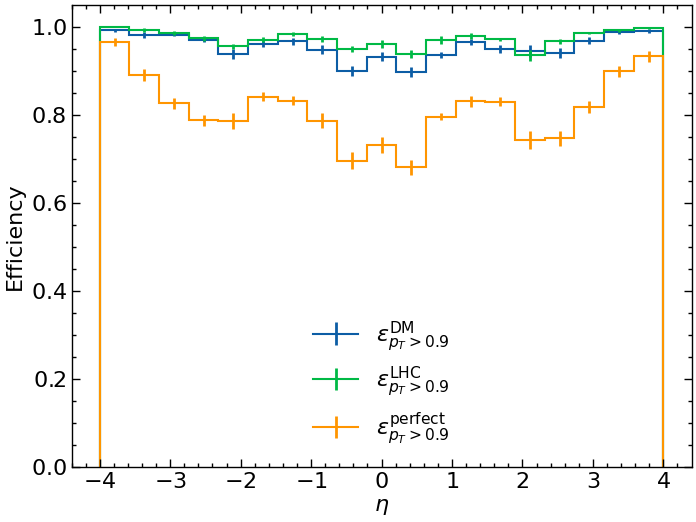

In [74]:
# vs_eta_ul = None
p = PerformancePlot(
    df=vs_eta, df_ul=None, xs=etas, var=vm["eta"].latex
)  # , model=model
# p.ax.set_xlim(-4.5, 4.5)
p.plot_var("double_majority", "C0", label=vm["double_majority_pt0.9"].latex)
p.plot_var("lhc", "C1", label=vm["lhc_pt0.9"].latex, plot_ul=False)
p.plot_var("perfect", "C2", label=vm["perfect_pt0.9"].latex)
p.add_legend()
p.ax.get_figure().savefig("vs_eta.pdf")

/tmp/ipykernel_2345810/4155649600.py:44: UserWarning: The label '_ignore' of (<matplotlib.patches.StepPatch object at 0x151532d1feb0>, <ErrorbarContainer object of 3 artists>) starts with '_'. It is thus excluded from the legend.
  self.ax.legend(all_handles, all_labels, **kwargs)


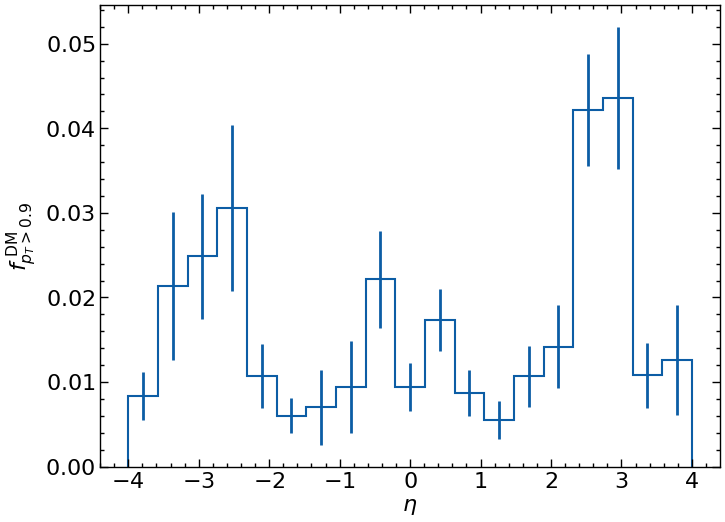

In [75]:
p = PerformancePlot(
    df=vs_eta,
    df_ul=None,
    xs=etas,
    var=vm["eta"].latex,
    y_label=r"$f^{\,\,\mathrm{DM}}_{p_T>0.9}$",
)
p.plot_var("fake_double_majority", "C0", label="_ignore")
p.add_legend()
p.ax.get_figure().savefig("fake_vs_eta.pdf")

In [76]:
vm["double_majority"].latex

'$\\epsilon^{\\mathrm{DM}}$'

In [78]:
vs_eta_ul

,n_particles,n_cleaned_clusters,perfect,double_majority,lhc,fake_perfect,fake_double_majority,fake_lhc,n_particles_err,n_cleaned_clusters_err,perfect_err,double_majority_err,lhc_err,fake_perfect_err,fake_double_majority_err,fake_lhc_err,eta_min,eta_max
0,55.3,55.1,0.989798,0.995024,1.0,0.006839,0.001613,0.0,2.454248,2.419596,0.003691,0.002535,0.0,0.003701,0.001613,0.0,-4.000000,-3.578947
1,57.5,57.5,0.919668,0.988476,1.0,0.081167,0.012500,0.0,1.875278,1.668333,0.013048,0.004367,0.0,0.013478,0.003861,0.0,-3.578947,-3.157895
2,64.9,72.6,0.820942,0.968303,1.0,0.265639,0.134721,0.0,3.686160,3.992215,0.015321,0.003591,0.0,0.019021,0.008783,0.0,-3.157895,-2.736842
3,69.7,73.0,0.866669,0.971224,1.0,0.170824,0.071141,0.0,2.970410,3.316625,0.010609,0.006824,0.0,0.014163,0.009542,0.0,-2.736842,-2.315789
4,75.9,74.8,0.957016,0.985910,1.0,0.029269,0.000000,0.0,3.529085,3.444158,0.007300,0.003763,0.0,0.006978,0.000000,0.0,-2.315789,-1.894737
5,83.5,82.1,0.945993,0.982960,1.0,0.038728,0.001111,0.0,4.437842,4.267318,0.007598,0.004435,0.0,0.005570,0.001111,0.0,-1.894737,-1.473684
6,87.1,86.2,0.947577,0.990017,1.0,0.042904,0.000000,0.0,4.757334,4.651881,0.009575,0.002918,0.0,0.008860,0.000000,0.0,-1.473684,-1.052632
7,82.7,81.4,0.939531,0.980907,1.0,0.045259,0.003340,0.0,3.127122,3.152424,0.009268,0.005802,0.0,0.009276,0.002294,0.0,-1.052632,-0.631579
8,89.7,86.8,0.899861,0.965834,1.0,0.069319,0.001190,0.0,3.797806,3.849387,0.008912,0.004759,0.0,0.009238,0.001190,0.0,-0.631579,-0.210526
9,84.2,81.6,0.923925,0.966673,1.0,0.045151,0.001087,0.0,3.498571,3.751148,0.009277,0.006869,0.0,0.008296,0.001087,0.0,-0.210526,0.210526


In [79]:
etas.shape

(21,)

In [80]:
vs_eta_uul = pd.read_csv(
    "/home/kl5675/Documents/23/git_sync/hyperparameter_optimization2/scripts/legacy/vs_eta_gc.csv"
)

In [81]:
vs_eta_cc = pd.read_csv(
    "/home/kl5675/Documents/23/git_sync/hyperparameter_optimization2/scripts/legacy/vs_eta_cc.csv"
)

ValueError: Size mismatch between "values" and "edges". Expected `len(values) + 1 == len(edges)`, but `len(values) = 17` and `len(edges) = 21`.

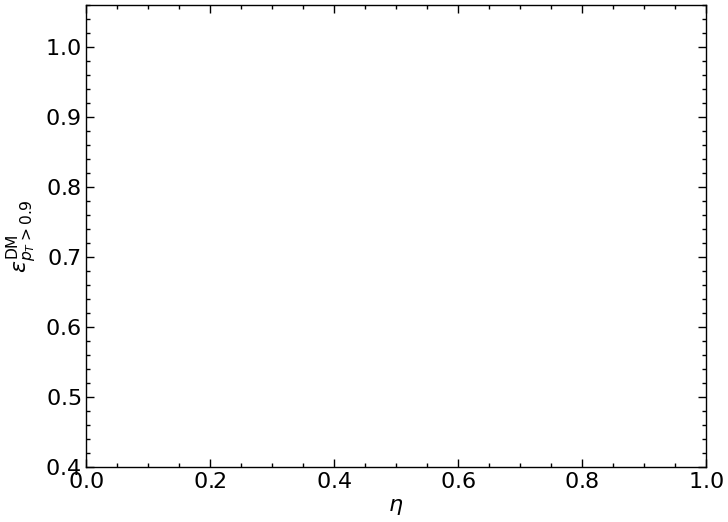

In [82]:
from gnn_tracking.analysis.efficiences import PerformanceComparisonPlot


p = PerformanceComparisonPlot(
    xs=etas,
    var="double_majority",
    x_label=vm["eta"].latex,
    ylabel=vm["double_majority_pt0.9"].latex,
)
p.ax.set_ylim(0.4, 1.06)
p.plot_var(vs_eta_uul, label="Perfect EC upper bound (graph construction)", color="C0")
p.plot_var(vs_eta_ul, label="Perfect EC upper bound (EF)", color="C1")
p.plot_var(vs_eta, label="Object condensation", color="C2")
p.plot_var(vs_eta_cc, label="Connected components (EF)", color="C3")
p.add_legend(loc="lower left", frameon=True)
p.ax.get_figure().savefig("vs_eta_dm.pdf")

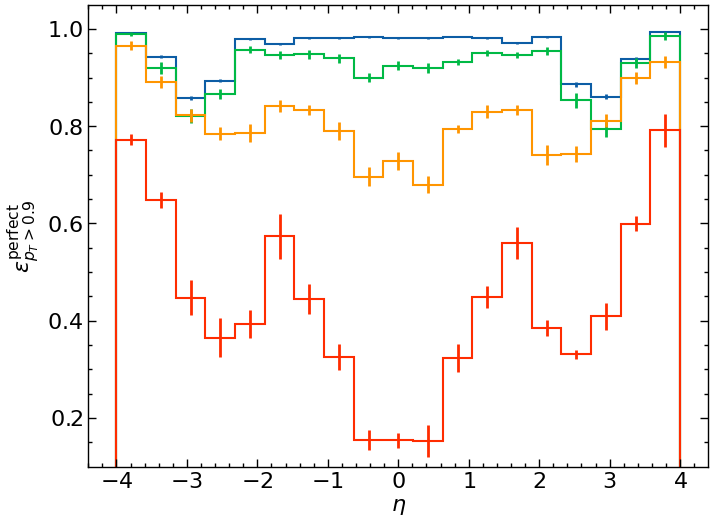

In [168]:
p = PerformanceComparisonPlot(
    xs=etas, var="perfect", x_label=vm["eta"].latex, ylabel=vm["perfect_pt0.9"].latex
)
p.ax.set_ylim(0.1, 1.05)
p.plot_var(vs_eta_uul, label="Perfect EC UB (graph construction)", color="C0")
p.plot_var(vs_eta_ul, label="Perfect EC UB (EF)", color="C1")
p.plot_var(vs_eta, label="Object condensation", color="C2")
p.plot_var(vs_eta_cc, label="Connected components (EF)", color="C3")
# p.add_legend()
p.ax.get_figure().savefig("vs_eta_perfect.pdf")